# Défi INSA Toulouse 2019

## Bibliographie

Application of Once Class SVM to detect anomaly : https://www.kaggle.com/amarnayak/once-class-svm-to-detect-anomaly/data

Code qui compare une SVM sur R et Python : http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_SVM_R_Python.pdf

Site pour comprendre ce qu'est une One-Class SVM : http://rvlasveld.github.io/blog/2013/07/12/introduction-to-one-class-support-vector-machines/

Fonction sur python de la fonction OneClassSVM (fonction équivalente à la section du site au-dessus de la One-Class SVM selon Schölkopf): https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html

Exemple utilisant la fonction One-class SVM : https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#sphx-glr-auto-examples-svm-plot-oneclass-py

## Traitement des données

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm

In [2]:
data_train = pd.read_hdf('train.hdf5')

Les données sont composées de séquences d'une minute de mesure d'accéléromètre à une fréquence de 1024 Herts.

60 * 1024 = 61440 variables/colonnes

Training Data : Le jeux de données d'apprentissage est composé de 1677 séquences.

Toutes ces séquences sont considérées comme des séquences normales.

Elles doivent être utilisées pour apprendre le comportement normal des accéléromètres.

In [3]:
data_valid = pd.read_hdf('validation.hdf5')

Validation Data : Le jeu de données de validation est composé de 594 séquences.
    
Les localisations et les angles peuvent, ou pas, être différentes de celles du jeu de données d'apprentissage. 

Un taux inconnu de ces séquences présentens un comportement anormal. 

Ces séquences doivent être détectées en les comparant aux séquences normales du jeu de données d'apprentissage.

In [4]:
data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
0,0.041259,0.041259,0.032573,0.023887,0.029315,0.041259,0.045602,0.038001,0.030401,0.032573,...,0.034744,-0.007600,-0.003257,0.065145,0.047773,-0.009772,0.031487,0.096632,0.077089,0.040173
1,-0.211722,-0.264924,-0.274696,-0.236694,-0.156349,-0.059716,0.005429,0.046687,0.153091,0.281210,...,0.260581,-0.004343,-0.241037,-0.636252,-0.953292,-0.980436,-0.846888,-0.838202,-0.880546,-0.739398
2,0.214105,0.154930,0.136640,0.013987,-0.038733,-0.015063,-0.111894,-0.104363,0.047340,-0.054871,...,0.040884,0.375490,0.699337,0.965085,1.086662,1.132926,1.279249,1.296464,0.937112,0.451879
3,-0.154837,-0.127768,-0.217638,-0.284770,-0.299929,-0.270694,-0.077960,0.092036,0.076877,0.154837,...,-0.286936,-0.171079,-0.036814,-0.024904,0.031400,0.140761,-0.011911,-0.173244,-0.063884,0.081208
4,-1.022780,-0.916376,-0.676425,-0.461445,-0.330069,-0.122690,0.178064,0.489675,0.799115,0.931577,...,1.009751,1.134613,0.836030,0.479903,0.109661,-0.285553,-0.628651,-0.916376,-1.010837,-0.804544


In [6]:
data_valid.head()

,0,1,2,3,4,5,6,7,8,9,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
0,0.070650,0.085524,0.076847,0.085524,0.120229,0.140061,0.107834,0.048340,0.014874,0.030987,...,0.018592,-0.017353,-0.049579,-0.061974,-0.022311,0.052058,0.091721,0.075608,0.045861,0.027268
1,-0.300685,-0.882656,-1.733789,-2.181179,-1.942328,-1.719240,-1.981126,-2.323034,-2.325459,-2.349708,...,0.454665,-0.782024,-1.725302,-1.829572,-1.170004,-0.278861,-0.152767,-1.035424,-2.312123,-3.199628
2,-0.056398,-0.152028,-0.058850,0.140994,0.170419,0.154480,0.270954,0.359228,0.334708,0.349420,...,0.023295,-0.019617,-0.062528,-0.094405,-0.105439,-0.123830,-0.166741,-0.159385,-0.106665,-0.131186
3,0.030618,0.020412,0.058747,0.124712,0.155828,0.161553,0.167777,0.170515,0.165038,0.141141,...,-0.073682,-0.052524,-0.023897,-0.009210,0.016429,0.058000,0.097828,0.114755,0.090360,0.054764
4,-1.071597,-6.912540,-13.677612,-16.463519,-15.790084,-11.653620,-7.668311,-9.942997,-14.321553,-13.704648,...,-5.227723,-6.107613,-6.577051,-6.123589,-5.324806,-4.965969,-4.464579,-3.442138,-3.794831,-6.133420


## Réprésentations graphiques

On transpose le jeu de données au préalable pour réaliser les graphiques

In [4]:
data_train_transpose = data_train.T # or df1.transpose()
data_train_transpose['index_col'] = data_train_transpose.index # ajoute une colonne index en dernière position
data_train_transpose.head()

,0,1,2,3,4,5,6,7,8,9,...,1668,1669,1670,1671,1672,1673,1674,1675,1676,index_col
0,0.041259,-0.211722,0.214105,-0.154837,-1.022780,0.802624,-0.334578,0.042344,0.004304,0.017324,...,-0.224020,0.044935,-0.048416,0.527766,-0.063989,0.993037,0.570550,0.630677,0.083910,0
1,0.041259,-0.264924,0.154930,-0.127768,-0.916376,0.759588,-0.232797,0.039087,0.019366,0.023821,...,-0.280331,0.052262,-0.046687,0.445075,0.017228,0.726052,0.253578,0.605010,0.044423,1
2,0.032573,-0.274696,0.136640,-0.217638,-0.676425,0.554090,-0.126685,0.038001,-0.087148,0.176492,...,-0.286451,-0.002442,0.027913,0.401297,0.015997,0.341885,-0.193841,0.477897,0.044423,2
3,0.023887,-0.236694,0.013987,-0.284770,-0.461445,0.391629,-0.184072,0.067317,-0.044112,0.108278,...,-0.248503,-0.003907,0.082751,0.558168,-0.321177,0.286314,-0.502279,0.155225,0.080208,3
4,0.029315,-0.156349,-0.038733,-0.299929,-0.330069,0.183979,-0.047642,0.053202,0.145247,-0.092036,...,-0.053863,0.053239,0.047922,0.761248,-0.503300,0.535177,-0.657108,-0.441229,0.097483,4


### Une séquence

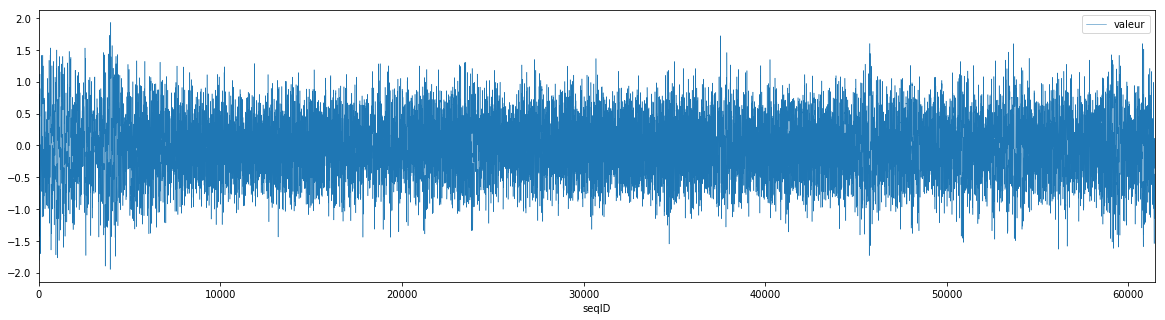

In [8]:
plot1 = {'seqID': np.arange(0,len(data_train_transpose)), 'valeur': data_train_transpose[658]}
plot1_pd = pd.DataFrame(plot1)

plot1_pd.plot(x="seqID", y="valeur", figsize=(20,5), linewidth=0.5)

### 3 séquences

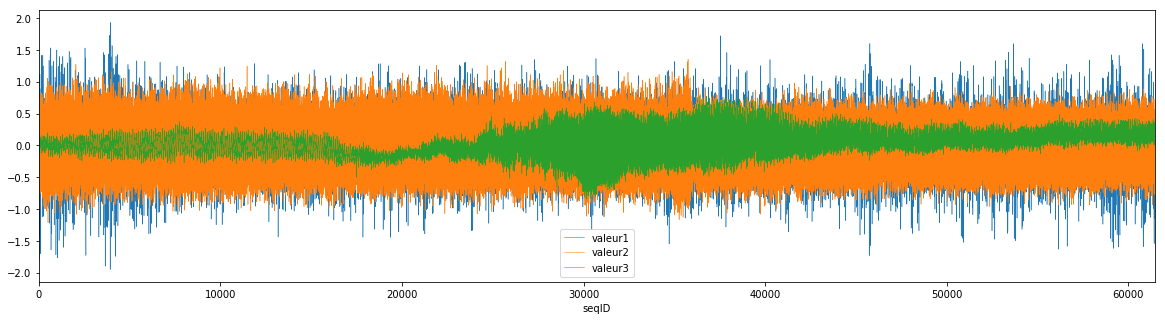

In [9]:
plot3 = {'seqID': np.arange(0,len(data_train_transpose)), 'valeur1': data_train_transpose[658], 
         'valeur2': data_train_transpose[333], 'valeur3': data_train_transpose[1250]}
plot3_pd = pd.DataFrame(plot3)

plot3_pd.plot(x="seqID", y=["valeur1", "valeur2", "valeur3"], figsize=(20,5), linewidth=0.5)

### Plusieurs séquences

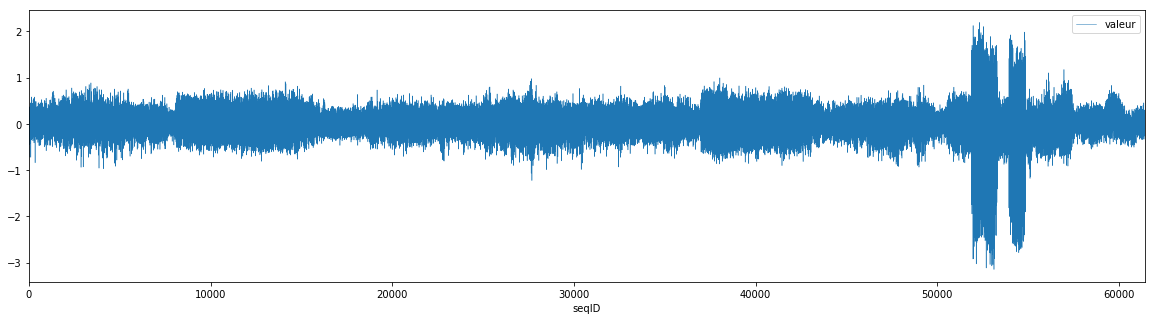

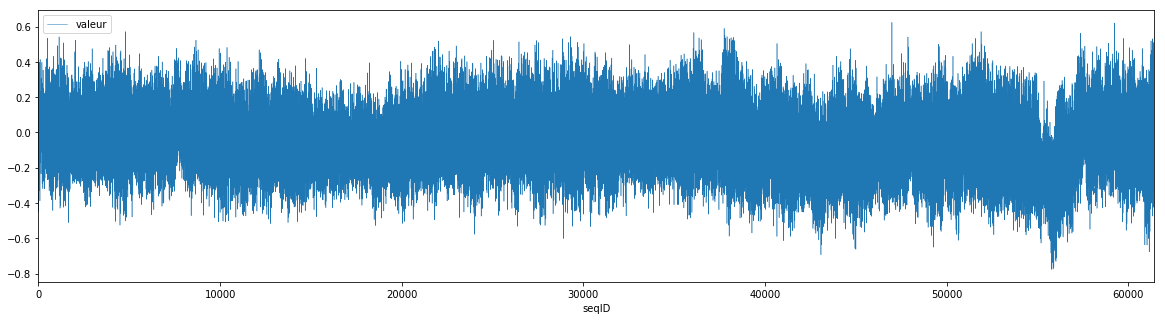

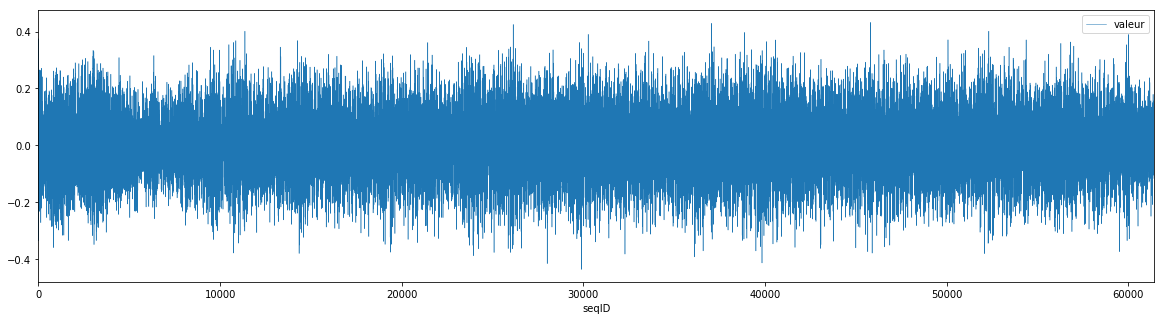

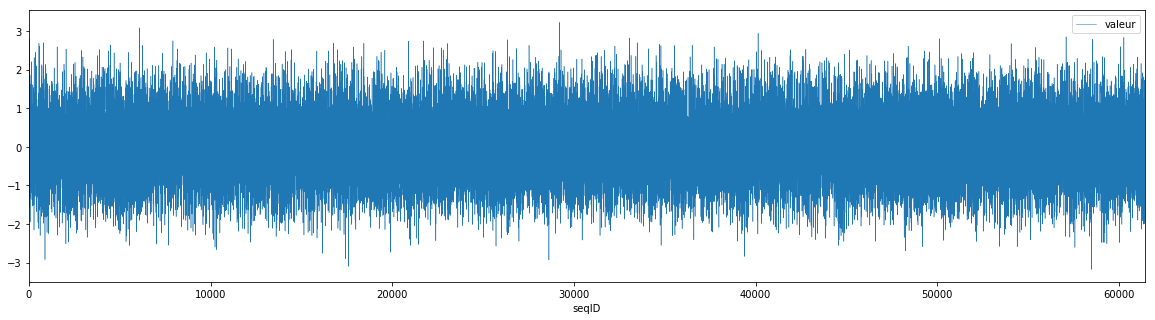

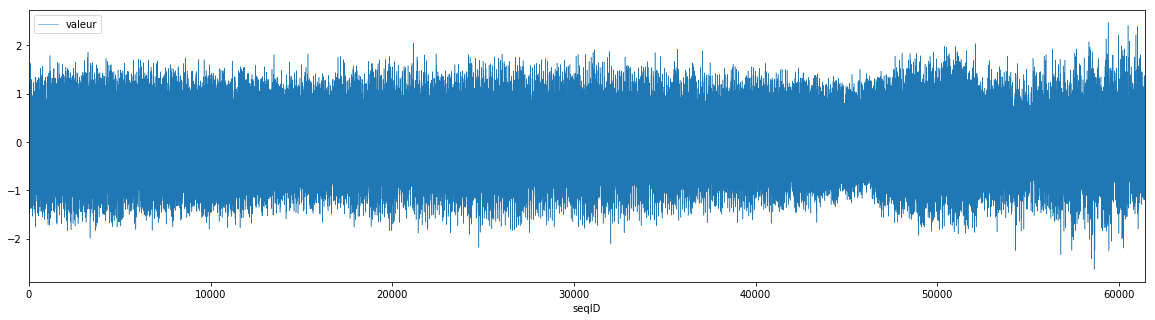

In [12]:
# Sélection de 5 séquences
data_train_selection = data_train.sample(n=5, random_state=1)
# Transpose le dataframe pour 
data_train_transpose = data_train_selection.T

# Pour chaque séquence, on trace le graphique correspondant
for i in data_train_transpose:    
    plot = {'seqID': np.arange(0,len(data_train_transpose)), 'valeur': data_train_transpose[i]}
    plot_pd = pd.DataFrame(plot)   
    plot_pd.plot(x="seqID", y='valeur', figsize=(20,5), linewidth=0.5)

## Algortihme de prédiction : SVM One-Class

In [15]:
SVM_oneclass = svm.OneClassSVM(kernel="rbf", gamma=0.001, nu=1)

In [16]:
# Training the algorithm with the features. 
# Etape couteuse en temps

SVM_oneclass.fit(data_train) 

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.001, kernel='rbf',
      max_iter=-1, nu=1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [17]:
pred_anomaly = SVM_oneclass.predict(data_valid)

# predict() : Effectue un ajustement sur X et renvoie les Y pour X.
# Renvoie -1 pour les valeurs aberrantes/outliers et 1 pour les valeurs normales.

In [18]:
from collections import Counter
Counter(pred_anomaly)

## -1 : anomalies. On ne souhaite pas obtenir beaucoup -1, mais seulement un petit nombre (?)

Counter({-1: 594})

On va essayer de réduire ce nombre d'anomalies, de -1, en changeant les paramètres : 
- kernel
- gammma
- nu 

### Kernel

In [19]:
# Définition des hyperparamètres pour One Class SVM
tb_count_moins1 = pd.DataFrame(index = ['Count outliers'])
tb_count_1 = pd.DataFrame(index = ['Count inliers'])

kernels = ["linear", "poly", "rbf", "sigmoid"]
for kernel in kernels:
    tb_pred = pd.DataFrame()
    SVM_oneclass = svm.OneClassSVM(kernel=kernel, gamma=0.001, nu=0.95)
    SVM_oneclass.fit(data_train) 
    pred_anomaly = SVM_oneclass.predict(data_valid)
    
    tb_count_1[kernel]= [int(Counter(pred_anomaly)[1])]
    tb_count_moins1[kernel]= [int(Counter(pred_anomaly)[-1])]
    
tb_count_kernel = pd.concat([tb_count_1, tb_count_moins1])
tb_count_kernel

,linear,poly,rbf,sigmoid
Count inliers,13,13,51,48
Count outliers,581,581,543,546


In [115]:
tb_count_kernel.to_csv('Tb count Anomalie par Kernel.csv', sep = ';', index = True, encoding = 'utf-8', na_rep = 'NA')

On a le moins d'outliers avec kernel='rbf'

### Nu

In [20]:
tb_count_moins1 = pd.DataFrame(index = ['Count outliers'])
tb_count_1 = pd.DataFrame(index = ['Count inliers'])

seq_nu = [0.25, 0.5, 0.75, 0.95]
for nu_i in seq_nu:
    tb_pred = pd.DataFrame()
    SVM_oneclass = svm.OneClassSVM(kernel="rbf", gamma=0.001, nu=nu_i)
    SVM_oneclass.fit(data_train) 
    pred_anomaly = SVM_oneclass.predict(data_valid)
    
    tb_count_1[nu_i] = [int(Counter(pred_anomaly)[1])]
    tb_count_moins1[nu_i] = [int(Counter(pred_anomaly)[-1])]
    
tb_count_nu = pd.concat([tb_count_1, tb_count_moins1])
tb_count_nu

,0.25,0.5,0.75,0.95
Count inliers,116,116,115,51
Count outliers,478,478,479,543


In [125]:
tb_count_nu.to_csv('Tb count Anomalie par nu.csv', sep = ';', index = True, encoding = 'utf-8', na_rep = 'NA')

On a le moins d'outliers avec nu=0.25

### Gamma

In [21]:
tb_count_moins1 = pd.DataFrame(index = ['Count outliers'])
tb_count_1 = pd.DataFrame(index = ['Count inliers'])

seq_gamma = [0.01, 0.001, 0.0001]
for gamma_i in seq_gamma:
    tb_pred = pd.DataFrame()
    SVM_oneclass = svm.OneClassSVM(kernel="rbf", gamma=gamma_i, nu=0.95)
    SVM_oneclass.fit(data_train) 
    pred_anomaly = SVM_oneclass.predict(data_valid)
    
    tb_count_1[gamma_i] = [int(Counter(pred_anomaly)[1])]
    tb_count_moins1[gamma_i] = [int(Counter(pred_anomaly)[-1])]
    
tb_count_gamma = pd.concat([tb_count_1, tb_count_moins1])
tb_count_gamma

,0.01,0.001,0.0001
Count inliers,17,51,52
Count outliers,577,543,542


In [127]:
tb_count_gamma.to_csv('Tb count Anomalie par gamma.csv', sep = ';', index = True, encoding = 'utf-8', na_rep = 'NA')

On a le moins d'outliers avec gamma=0.0001

 On va utiliser les paramètres qui minimise le nombre de -1 :
qui sont kernel = 'rbf', gamma= '0.0001', et nu= '0.25'

In [90]:
kernel = 'rbf'
gamma = 0.0001
nu = 0.25
SVM_oneclass = svm.OneClassSVM(kernel=kernel, gamma=gamma, nu=nu)
SVM_oneclass.fit(data_train) 
pred_anomaly = SVM_oneclass.predict(data_valid)

In [91]:
from collections import Counter
Counter(pred_anomaly)
# {1: 279, -1: 315}

Counter({1: 279, -1: 315})

In [131]:
# score_samples(self, X) : Raw scoring function of the samples.
from statistics import mean
moyenne_scores_ech = mean(SVM_oneclass.score_samples(data_valid))

In [39]:
type(pred_anomaly)

numpy.ndarray

In [92]:
pred_anomaly2 = pd.DataFrame(pred_anomaly)

In [93]:
pred_anomaly2 = pred_anomaly2.replace(1, 0)
pred_anomaly2 = pred_anomaly2.replace(-1, 1)

In [ ]:
# Sous quel format dois-je envoyer ma prédiction?
# Votre fichier réponse y_test_template doit être un fichier .csv et utiliser l'élément ";" comme séparateur.
#Votre fichier final doit avoir cette forme : 
# seqID;anomaly
# 0;0
# 1;0
# 2;1
# 3;0
# ...;...
# ou : 
# seqID : Numéro de la séquence. (int) 
# prediction : 1 si la séquence est anormale, 0 sinon. (int) 

In [94]:
data = {'seqID': np.arange(0,len(data_valid)), 'anomaly': pred_anomaly2[0]}
y_test_template = pd.DataFrame(data)

On s'assure que les données sont bien des entiers

In [95]:
y_test_template["seqID"] = y_test_template["seqID"].astype(int)

In [96]:
y_test_template["anomaly"] = y_test_template["anomaly"].astype(int)

### Etude des anomalies repérées avec cette méthode

On veut maintenant regarder à quoi ressemble les séquences qui ont été classés comme des anomalies.

C'est à dire celles qui ont des 1 dans la colonne 'anomaly' de y_test_template

In [101]:
anomalies = y_test_template[y_test_template.anomaly == 1]
y_anomaly = pd.DataFrame(anomalies)
y_anomaly.head()

,seqID,anomaly
1,1,1
4,4,1
5,5,1
7,7,1
8,8,1


Les séquences 1, 4, 5, etc sont considérées comme anormales, on représente les cinq premières ci-dessous.

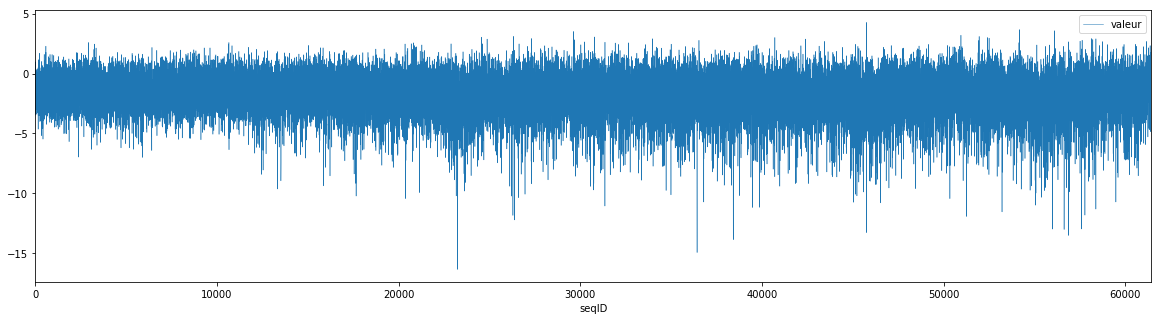

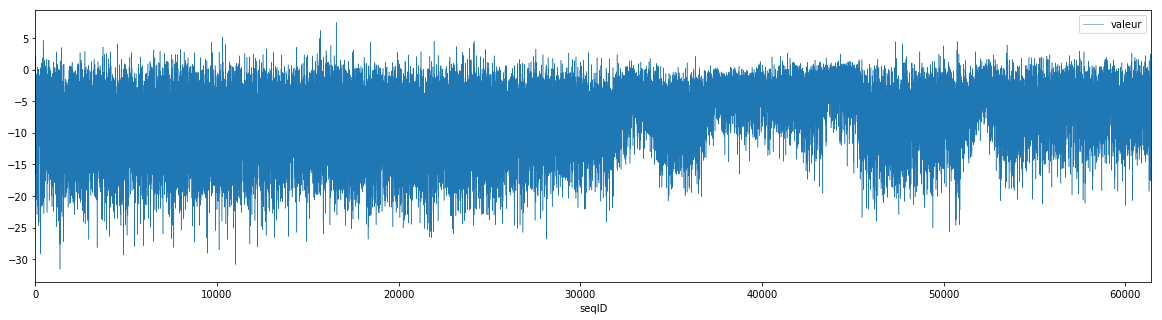

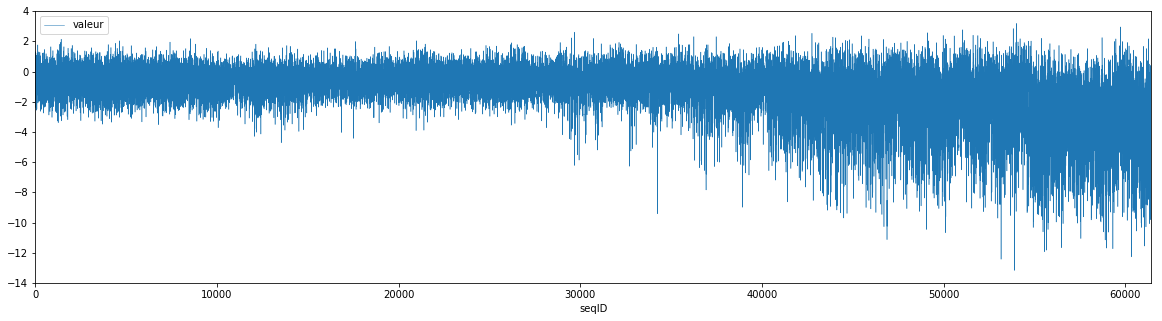

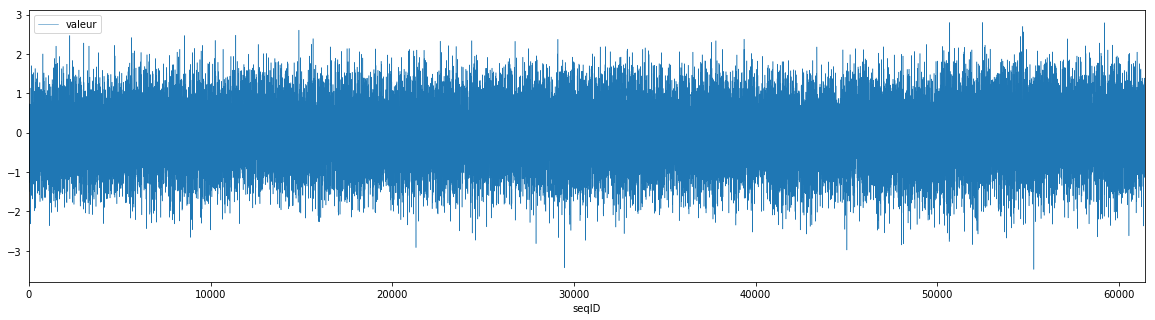

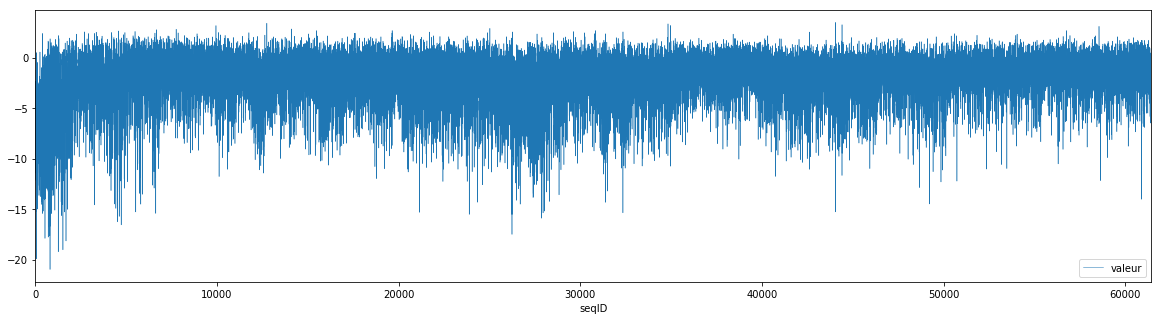

In [103]:
data_valid_transpose = data_valid.T
data_valid_transpose['index_col'] = data_valid_transpose.index # ajoute une colonne index en dernière position

liste_anomaly = [1,4,5,7,8]
for i in liste_anomaly:
    plot_anomaly = {'seqID': np.arange(0,len(data_valid_transpose)), 'valeur': data_valid_transpose[i]}
    plot_anomaly_pd = pd.DataFrame(plot_anomaly)
    
    plot_anomaly_pd.plot(x="seqID", y="valeur", figsize=(20,5), linewidth=0.5)

On peut remarquer que les séquences représentées ici ont des valeurs beaucoup négatives et s'étendent sur des intervalles beaucoup plus large [5;-30]

### Exportation du fichier sous .csv

In [24]:
y_test_template.to_csv('y_test_template.csv',  index = False, sep=";")

Le F1 Score est de: 0.839869281046 avec cette méthode et ces hyperparamètres.

Precision: 0.815873015873 

Recall: 0.86531986532

## Analyse fréquentielle FFT globale (Transformation de Fourier)

In [5]:
from scipy.fftpack import fft, ifft
fft_dtrain = pd.DataFrame(fft(data_train))
fft_dval = pd.DataFrame(fft(data_valid))

dtrain_absolute = np.absolute(fft_dtrain)
dval_absolute = np.absolute(fft_dval)

### Réprésentations graphiques

On transpose le jeu de données au préalable pour réaliser les graphiques

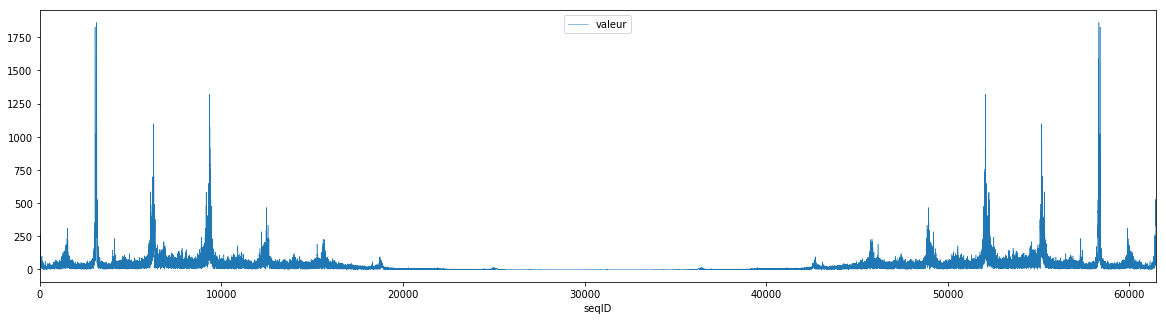

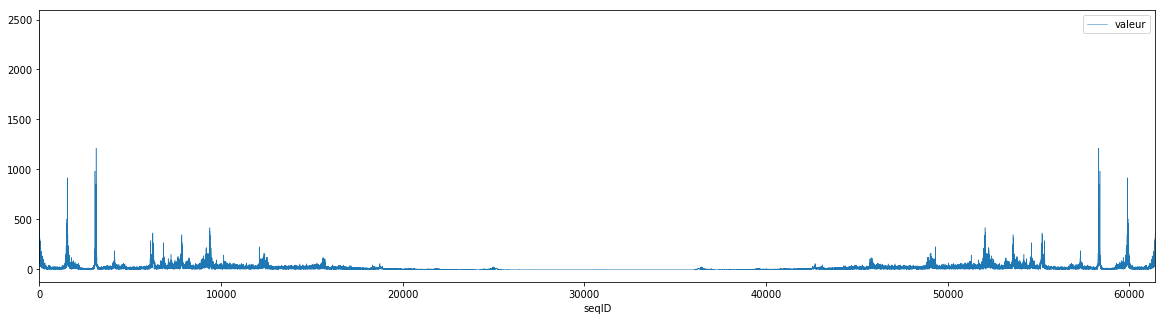

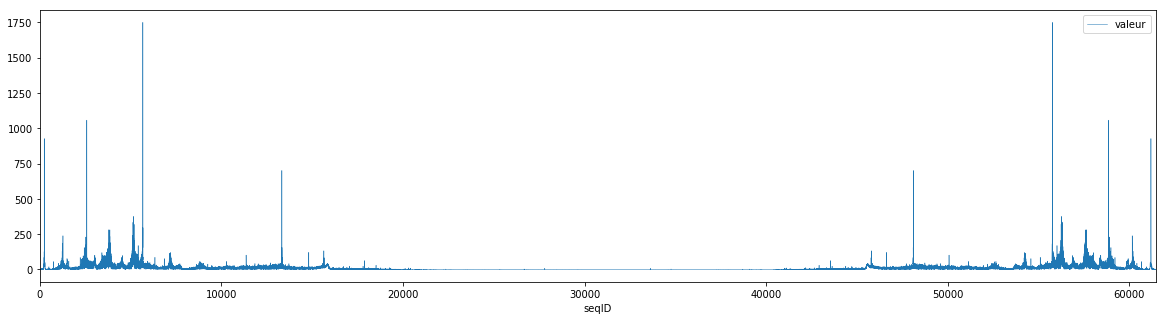

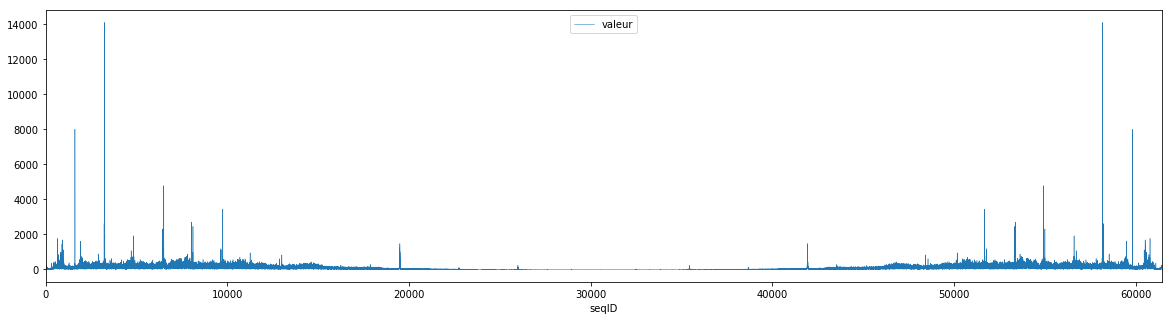

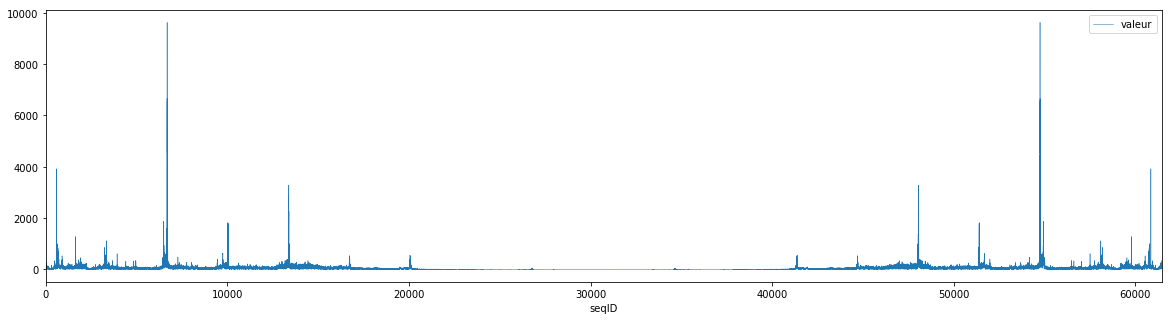

In [5]:
# Sélection de 5 séquences
data_train_selection = dtrain_absolute.sample(n=5, random_state=1)
# Transpose le dataframe pour 
data_train_transpose = data_train_selection.T

# Pour chaque séquence, on trace le graphique correspondant
for i in data_train_transpose:    
    plot = {'seqID': np.arange(0,len(data_train_transpose)), 'valeur': data_train_transpose[i]}
    plot_pd = pd.DataFrame(plot)   
    plot_pd.plot(x="seqID", y='valeur', figsize=(20,5), linewidth=0.5)

Sur le site https://defi-ia.insa-toulouse.fr/account, on a une colonne Recall (=Rappel), qui est de la forme $R=\frac{TP}{TP+NP}$

TP : True Positive : c'est le nombre d'anomalies qu'on a bien détectés. 

NP : nombre d'anomalies non détectés.

TP+NP : c'est le nombre d'anomalies totale dans notre jeu de validation.

La meilleure équipe dans le classement pour le défi à un rappel de 0.996632996633.

Imaginons qu'il lui manque une anomalie qui n'a pas été détecté.

Ainsi, on essaye de trouve le nombre de True Positive : $R=\frac{TP}{TP+1}=0.99663299633$

On obtient TP qui est environ égale à 300.

On va essayer de trouver un nombre d'anomalies, -1, proche de 300 en changeant les paramètres : 
- kernel
- gammma
- nu 

### Kernel

In [6]:
from collections import Counter

In [6]:
# Définition des hyperparamètres pour One Class SVM
tb_count_moins1 = pd.DataFrame(index = ['Count outliers'])
tb_count_1 = pd.DataFrame(index = ['Count inliers'])

kernels = ["linear", "poly", "rbf", "sigmoid"]
for kernel in kernels:
    tb_pred = pd.DataFrame()
    SVM_oneclass = svm.OneClassSVM(kernel=kernel, gamma=0.001, nu=0.95)
    SVM_oneclass.fit(dtrain_absolute) 
    pred_anomaly = SVM_oneclass.predict(dval_absolute)
    
    tb_count_1[kernel]= [int(Counter(pred_anomaly)[1])]
    tb_count_moins1[kernel]= [int(Counter(pred_anomaly)[-1])]
    
tb_count_kernel = pd.concat([tb_count_1, tb_count_moins1])
tb_count_kernel

,linear,poly,rbf,sigmoid
Count inliers,194,201,0,0
Count outliers,400,393,594,594


On a le moins d'outliers avec kernel='poly'

### Nu

In [ ]:
tb_count_moins1 = pd.DataFrame(index = ['Count outliers'])
tb_count_1 = pd.DataFrame(index = ['Count inliers'])

seq_nu = [0.25, 0.5, 0.75, 0.95]
for nu_i in seq_nu:
    tb_pred = pd.DataFrame()
    SVM_oneclass = svm.OneClassSVM(kernel="poly", gamma=0.001, nu=nu_i)
    SVM_oneclass.fit(dtrain_absolute) 
    pred_anomaly = SVM_oneclass.predict(dval_absolute)
    
    tb_count_1[nu_i] = [int(Counter(pred_anomaly)[1])]
    tb_count_moins1[nu_i] = [int(Counter(pred_anomaly)[-1])]
    
tb_count_nu = pd.concat([tb_count_1, tb_count_moins1])
tb_count_nu

On a le moins d'outliers avec nu=...

### Gamma

In [ ]:
tb_count_moins1 = pd.DataFrame(index = ['Count outliers'])
tb_count_1 = pd.DataFrame(index = ['Count inliers'])

seq_gamma = [0.01, 0.001, 0.0001]
for gamma_i in seq_gamma:
    tb_pred = pd.DataFrame()
    SVM_oneclass = svm.OneClassSVM(kernel="poly", gamma=gamma_i, nu=0.5)
    SVM_oneclass.fit(dtrain_absolute) 
    pred_anomaly = SVM_oneclass.predict(dval_absolute)
    
    tb_count_1[gamma_i] = [int(Counter(pred_anomaly)[1])]
    tb_count_moins1[gamma_i] = [int(Counter(pred_anomaly)[-1])]
    
tb_count_gamma_fft = pd.concat([tb_count_1, tb_count_moins1])
tb_count_gamma_fft

On a le moins d'outliers avec gamma=...

 On va utiliser les paramètres qui se rapproche du nombre 300 pour le nombres d'anomalies (-1) :
qui sont kernel = '...', gamma= '....', et nu= '....'

In [ ]:
kernel = 'poly'
gamma = 0.25
nu = 0.001
SVM_oneclass_fft = svm.OneClassSVM(kernel=kernel, gamma=gamma, nu=nu)
SVM_oneclass_fft.fit(dtrain_absolute) 
pred_anomaly_fft = SVM_oneclass_fft.predict(dval_absolute)

In [10]:
Counter(pred_anomaly_fft)
# kernel = 'poly'
# gamma = 0.25
# nu = 0.01

Counter({1: 553, -1: 41})

In [8]:
Counter(pred_anomaly_fft)  
# kernel = 'poly'
# gamma = 0.25
# nu = 0.0001

Counter({1: 566, -1: 28})

Conversion en .csv du fichier de sortie. 

On a pas encore choisi les hyperparamètres du modèle pour trouver y_test_template_fft

In [9]:
pred_anomaly_fft2 = pd.DataFrame(pred_anomaly_fft)
pred_anomaly_fft2 = pred_anomaly_fft2.replace(1, 0)
pred_anomaly_fft2 = pred_anomaly_fft2.replace(-1, 1)

In [10]:
data_fft = {'seqID': np.arange(0,len(dval_absolute)), 'anomaly': pred_anomaly_fft2[0]}
y_test_template_fft = pd.DataFrame(data_fft)

On s'assure que les données sont bien des entiers

In [11]:
y_test_template_fft["seqID"] = y_test_template_fft["seqID"].astype(int)
y_test_template_fft["anomaly"] = y_test_template_fft["anomaly"].astype(int)

In [12]:
y_test_template_fft.to_csv('y_test_template_fft.csv',  index = False, sep=";")

### Etude des anomalies repérées avec cette méthode

On veut maintenant regarder à quoi ressemble les séquences qui ont été classés comme des anomalies.

C'est à dire celles qui ont des 1 dans la colonne 'anomaly' de y_test_template

In [13]:
anomalies = y_test_template_fft[y_test_template_fft.anomaly == 1]
y_anomaly = pd.DataFrame(anomalies)
y_anomaly.head()

,seqID,anomaly
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1


Les séquences ..,..,.. etc sont considérées comme anormales, on représente les cinq premières ci-dessous.

In [14]:
data_valid_transpose = dval_absolute.T
data_valid_transpose['index_col'] = data_valid_transpose.index # ajoute une colonne index en dernière position

liste_anomaly = []
for i in liste_anomaly:
    plot_anomaly = {'seqID': np.arange(0,len(data_valid_transpose)), 'valeur': data_valid_transpose[i]}
    plot_anomaly_pd = pd.DataFrame(plot_anomaly)
    
    plot_anomaly_pd.plot(x="seqID", y="valeur", figsize=(20,5), linewidth=0.5)